## Enunciado

Considere la información del proyecto cuya información aparece en la tabla adjunta:  
1. ¿Cuál es la probabilidad de terminar el proyecto entre 10 y 12 periodos?  
2. Indique cuales serían las actuaciones a llevar a cabo para reducir con mínimo sobrecoste la duración media del proyecto a 9 periodos.  
3. Indique cuales serían las actuaciones para poder ejecutar el proyecto con un límite en los recursos de 8 recursos por periodo durante los primeros ocho periodos.  
4. Calcule el valor del CPI y del SPI para el punto de control de 11 periodos.  


In [1]:
%%capture
import os, sys
from jupyter_tikz import TexFragment
from IPython.display import display, HTML, Markdown

"""!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"



if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files
"""
# To find local version of the library
sys.path.append('../src')

from pmule import PredecessorTable, ProjectGraph
%cd ~/temp

In [2]:
import pandas as pd
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, duracion, duracion_tope, desviación, coste_planificado, coste_real, duracion_real, realizado, cur, recursos
     ('A',      'D      ',       2,         1,              0.2,         60,              80,          2,           100,   80,    4 ),
     ('B',      'A      ',       2,         1,              0.3,         70,              60,          2,            80,   10,    2 ),
     ('C',      'B      ',       3,         1,              0.4,         50,               0,          0,             0,   40,    1 ),
     ('D',      '---    ',       4,         3,              0.5,         40,              50,          5,           100,   20,    4 ),
     ('E',      'A      ',       1,         1,              0.1,         30,              30,          3,           100,   30,    3 ),
     ('F',      'D,E    ',       2,         1,              0.3,         10,              10,          3,            80,   40,    5 ),
     ('G',      '---    ',       4,         1,              0.1,         40,              50,          3,           100,   20,    4 ),
     ('H',      'G      ',       4,         2,              0.5,        110,             140,          4,            90,   50,    2 ),
     ('I',      'D      ',       2,         1,              0.1,         90,              70,          1,            50,   60,    3 ),
     ('J',      'F,H,I,K',       2,         1,              0.4,         50,               0,          0,             0,   70,    1 ),
     ('K',      'D,G    ',       4,         1,              0.2,         40,              30,          2,            60,   90,    2 ),
     ('L',      'H,K    ',       1,         1,              0.2,         30,               0,          0,             0,   10,    3 ),
] ,columns=['activity', 'predecessor', 'duration', 'cap_duration', 'standard_deviation', 'planned_value', 'actual_cost',
            'actual_duration', 'performed', 'ucr', 'resources']).set_index('activity')
tabla = datos_enunciado.copy()
tabla.columns = ["Pred.", 'Duration', 'Cap <br> duration', 'Standard <br> deviation', 'PV', 'AC',
            'Actual <br> duration', 'Performed', 'UCR', 'Resources']
display(tabla.style.set_properties(**{'text-align': 'center'}).format(precision=2))

,Pred.,Duration,Cap duration,Standard deviation,PV,AC,Actual duration,Performed,UCR,Resources
activity,,,,,,,,,,
A,D,2,1,0.20,60,80,2,100,80,4
B,A,2,1,0.30,70,60,2,80,10,2
C,B,3,1,0.40,50,0,0,0,40,1
D,---,4,3,0.50,40,50,5,100,20,4
E,A,1,1,0.10,30,30,3,100,30,3
F,"D,E",2,1,0.30,10,10,3,80,40,5
G,---,4,1,0.10,40,50,3,100,20,4
H,G,4,2,0.50,110,140,4,90,50,2
I,D,2,1,0.10,90,70,1,50,60,3


{{< pagebreak >}}

## Solución
### Apartado 1

> ¿Cuál es la probabilidad de terminar el proyecto entre 10 y 12 semanas?


#### Duración media del proyecto

In [3]:
from pmule import ProjectGraph, PredecessorTable

In [4]:
datos_proyecto=datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K,L
activities,,,,,,,,,,,,
A,,,,True,,,,,,,,
B,True,,,,,,,,,,,
C,,True,,,,,,,,,,
D,,,,,,,,,,,,
E,True,,,,,,,,,,,
F,,,,,True,,,,,,,
G,,,,,,,,,,,,
H,,,,,,,True,,,,,
I,,,,True,,,,,,,,


##### Grafo PERT con numeración de nodos

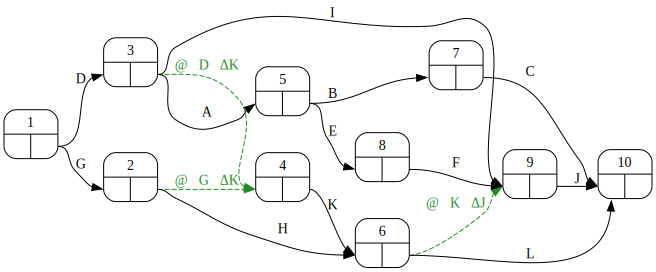

In [5]:
proyecto = prelaciones.create_project()
proyecto.pert()

{{< pagebreak >}}

##### Matriz de Zaderenko

In [6]:
proyecto.zaderenko(durations=datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,9,10,early
1,,4.0,4.0,,,,,,,,0.0
2,,,,0.0,,4.0,,,,,4.0
3,,,,0.0,2.0,,,,2.0,,4.0
4,,,,,,4.0,,,,,4.0
5,,,,,,,2.0,1.0,,,6.0
6,,,,,,,,,0.0,1.0,8.0
7,,,,,,,,,,3.0,8.0
8,,,,,,,,,2.0,,7.0
9,,,,,,,,,,2.0,9.0
10,,,,,,,,,,,11.0


In [7]:
resultados_pert = proyecto.calculate_pert(durations=datos_proyecto['duration'])
resultados_pert['nodes']

,early,late
1,0,0
2,4,5
3,4,4
4,4,5
5,6,6
6,8,9
7,8,8
8,7,7
9,9,9
10,11,11


##### Duración media del proyecto

In [8]:
duracion_media_proyecto = int(proyecto.duration(durations=datos_proyecto['duration']))

In [9]:
Markdown(f"La duración media del proyecto es {duracion_media_proyecto}")

La duración media del proyecto es 11

{{< pagebreak >}}

#### Varianza de la duración del proyecto
Para determinar la varianza de la duración del proyecto es necesario determinar la varianza de cada rama del camino crítico.

##### Holguras

In [10]:
resultados_pert['activities'][['H_total']]

,H_total
@∇D⤑ΔK,1
@∇G⤑ΔK,1
@∇K⤑ΔJ,1
A,0
B,0
C,0
D,0
E,0
F,0
G,1


##### Camino crítico

In [11]:
camino_critico = proyecto.critical_path(durations=datos_proyecto['duration'])
camino_critico

{'Route_1': ['A', 'B', 'C', 'D'], 'Route_2': ['A', 'D', 'E', 'F', 'J']}

##### Grafo PERT con indicación del camino crítico

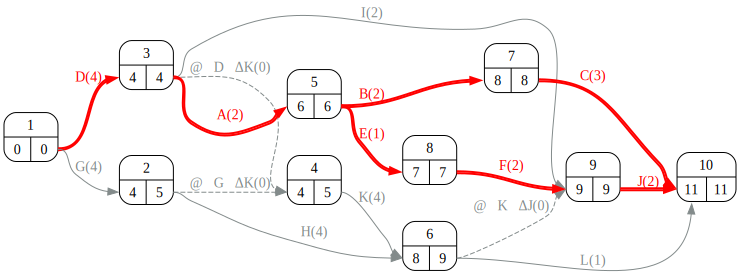

In [12]:
proyecto.pert(durations=datos_proyecto['duration'])

##### Varianza de cada rama

A la vista del grafo PERT el camino crítico se compone de 2 ramas.

In [13]:
datos_proyecto['variance'] = datos_proyecto.eval('standard_deviation ** 2')
desviacion_proyecto = round(float(proyecto.standard_deviation(durations=datos_proyecto['duration'],
                                                   variances=datos_proyecto['variance']) )
                            , 2)
desviacion_proyecto

Variance path: Route_1 : 0.54
Variance path: Route_2 : 0.55
Project duration variance: 0.55
Project duration standard deviation: 0.7416198487095663


0.74

#### Probabilidad de terminar entre 10 y 12 periodos

In [14]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_12 = norm.cdf(12, loc=duracion_media_proyecto, scale=desviacion_proyecto)
probabilidad_de_terminar_antes_de_10 = norm.cdf(10, loc=duracion_media_proyecto, scale=desviacion_proyecto)

probabilidad_de_terminar_entre_10_y_12 = probabilidad_de_terminar_antes_de_12 - probabilidad_de_terminar_antes_de_10
round(float(probabilidad_de_terminar_entre_10_y_12 * 100), 2)

82.34

### Apartado 2
> Indique cuales serían las actuaciones a llevar a cabo para reducir con mínimo sobrecoste la duración media del proyecto a 9 periodos.

#### Reducción a 9 periodos

In [15]:
ackoff, best_option, duration, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                min_durations=datos_proyecto['cap_duration'],
                costs=datos_proyecto['ucr'],
                reduction=2)
ackoff

Step: 0,	 Critical paths: ['Route_1', 'Route_2']
		 Best option: ['D'], 	 Cost: 20
Step: 1,	 Critical paths: ['Route_1', 'Route_2', 'Route_6', 'Route_8']
		 Best option: ['B', 'G', 'F'], 	 Cost: 70

--------------------------------------------------------------------------------


,A,B,C,D,E,F,G,H,I,J,K,L,0,1,2
Route_1,80.0,10.0,40.0,20.0,,,,,,,,,11.0,10.0,9.0
Route_2,80.0,,,20.0,30.0,40.0,,,,70.0,,,11.0,10.0,9.0
Route_3,,,,20.0,,,,,60.0,70.0,,,8.0,7.0,7.0
Route_4,,,,20.0,,,,,,70.0,90.0,,10.0,9.0,9.0
Route_5,,,,20.0,,,,,,,90.0,10.0,9.0,8.0,8.0
Route_6,,,,,,,20.0,50.0,,70.0,,,10.0,10.0,9.0
Route_7,,,,,,,20.0,50.0,,,,10.0,9.0,9.0,8.0
Route_8,,,,,,,20.0,,,70.0,90.0,,10.0,10.0,9.0
Route_9,,,,,,,20.0,,,,90.0,10.0,9.0,9.0,8.0
0,1.0,1.0,2.0,1.0,0.0,1.0,3.0,2.0,1.0,1.0,3.0,0.0,,,


### Apartado 3
> Indique cuales serían las actuaciones para poder ejecutar el proyecto con un límite en los recursos de 8 recursos por periodo durante los primeros ocho periodos.

Para responder este apartado es necesario representar la demanda de recursos a lo largo del tiempo.

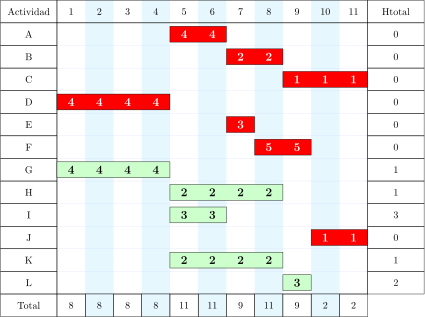

In [16]:
proyecto_asignacion = proyecto.copy()
gantt, dibujo = proyecto_asignacion.gantt(datos_proyecto,
                          'duration',
                          'resources',
                          total='fila',
                          holguras=True, tikz=True)
TexFragment(dibujo).run_latex()

La demanda de recursos actual infringe el límite impuesto. Es necesario aplicar el algoritmo de asignación.

#### Algoritmo de asignación

 El primer periodo problemático es el 5.

##### Asignación periodo 5

De las actividades inicialmente programadas para el periodo 5 la actividad A es crítica y se programa consumiendo 4 recursos. Atendiendo a la holgura para la prioridad se elige programar las actividades H y K, desplazando I.

Suma de cuadrados: 795 



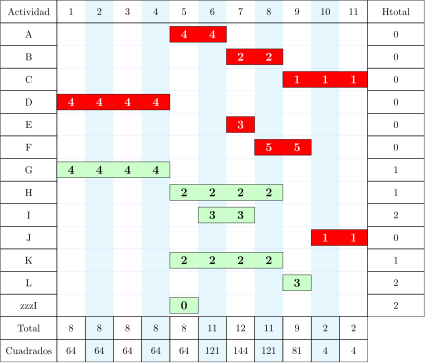

In [17]:
duration_resources = datos_proyecto[['duration','resources']].copy()
duration_resources, df, dibujo = proyecto_asignacion.desplazar(data=duration_resources, duration_label='duration', resource_label='resources', I = 1, tikz=True)
TexFragment(dibujo.replace('💤', 'zzz')).run_latex()

##### Asignación periodo 6

Las actividades A, H y K ya se están ejecutando y no se interrumpen. Se desplaza I.

Suma de cuadrados: 813 



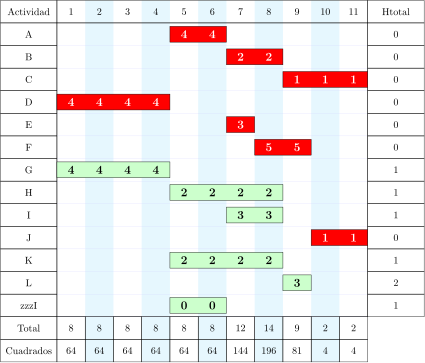

In [18]:
duration_resources, df, dibujo = proyecto_asignacion.desplazar(data=duration_resources, duration_label='duration', resource_label='resources', tikz=True, I = 1)
TexFragment(dibujo.replace('💤', 'zzz')).run_latex()

##### Asignación periodo 7

Las actividades H y K ya están en ejecución y no se interrumpen. B y E son críticas pero E es más corta. Se programa H, K y E desplazando B e I.

Suma de cuadrados: 807 



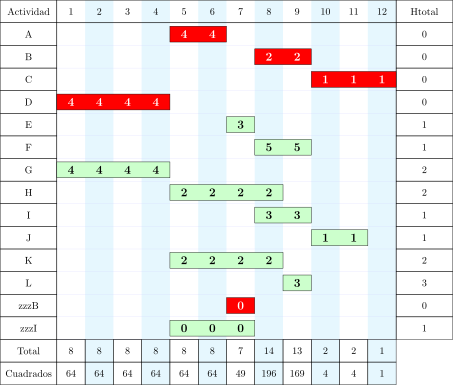

In [19]:
duration_resources, df, dibujo = proyecto_asignacion.desplazar(data=duration_resources, duration_label='duration', resource_label='resources', tikz=True, I = 1, B = 1)
TexFragment(dibujo.replace('💤', 'zzz')).run_latex()

##### Asignación periodo 8

En este periodo se está ejecutando H y K que no se interrumpen. Se ejecuta B por ser crítica y se desplazan F e I.

Suma de cuadrados: 727 



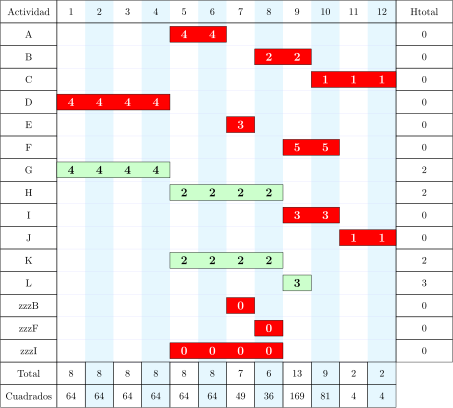

In [20]:
duration_resources, df, dibujo = proyecto_asignacion.desplazar(data=duration_resources, duration_label='duration', resource_label='resources', tikz=True, F = 1, I = 1)
TexFragment(dibujo.replace('💤', 'zzz')).run_latex()

### Apartado 4
> Calcule el valor del CPI y del SPI para el punto de control de 11 periodos.


In [21]:
PV = int(datos_proyecto['planned_value'].sum())
EV = int(datos_proyecto.eval('planned_value * performed / 100').sum())
AC = int(datos_proyecto['actual_cost'].sum())
CPI = float(EV/AC)
SPI=float(EV/PV)

In [22]:
Markdown(f"""Utilizando CPI=EV/AC y SPI=EV/PV, tenemos:  
PV={PV}  
EV={EV}  
AC={AC}  
CPI={round(CPI,2)}  
SPI={round(SPI,2)}""")

Utilizando CPI=EV/AC y SPI=EV/PV, tenemos:  
PV=620  
EV=402  
AC=520  
CPI=0.77  
SPI=0.65